# __Examples__

## __Model-X Knockoffs with Lasso Feature Importance Scores__

In [1]:
import adelie as ad
import knockpy
import matplotlib.pyplot as plt
import numpy as np

In this example, we cover a neat application of Lasso in a popular statistical method called *Knockoffs*,
pioneered by Rina Barber and Emmanuel Candès.
We briefly describe the Knockoff framework.
Knockoffs are fictitious features generated
by the user that look similar to an already given set of features.
As soon as these knockoffs enjoy certain statistical
properties relating their distributions to the original features, we may use them to determine which of the original features are important for predicting the response while controlling for the *false discovery rate* (FDR).
For an in-depth treatment of Knockoffs,
we provide the following references:

- [Panning for Gold: ‘Model-X’ Knockoffs for High Dimensional Controlled Variable Selection](https://academic.oup.com/jrsssb/article/80/3/551/7048447)
- [Papers about Knockoffs](https://web.stanford.edu/group/candes/knockoffs/papers.html)
- [Knockoffs on Wikipedia](https://en.wikipedia.org/wiki/Knockoffs_(statistics))

We will work under the Model-X framework.
Let's begin with some data.
We assume $n$ independent samples $X_i \sim N(0, \Sigma)$
where $\Sigma \in \mathbb{R}^{p \times p}$ is the equi-correlation matrix with correlation $\rho$.
Our response $y$ is generated from a linear model
$y = X \beta + \sigma \varepsilon$
where the first half of the coefficients $\beta$ are generated from $N(0,1)$ (and the rest set to zero),
$\varepsilon \sim N(0, I_n)$,
and $\sigma$ such that the signal-to-noise ratio is $1$.

In [2]:
n = 10000       # number of samples
p = 100         # number of features
n_h1 = p // 2   # number of features with signal
rho = 0.3       # equi-correlation
seed = 0        # random seed

np.random.seed(seed)
W = np.random.normal(0, 1, n)
Z = np.random.normal(0, 1, (n, p))
X = np.sqrt(rho) * W[:, None] + np.sqrt(1-rho) * Z
y = X[:, :n_h1] @ np.random.normal(0, 1, n_h1) + np.sqrt(n_h1) * np.random.normal(0, 1, n)

Next, we generate our Model-X knockoffs.
The definition of Model-X knockoffs states that each knockoff $\tilde{X}_i \in \mathbb{R}^{p}$
must satisfy the exchangeability condition that swapping any subset of the features with
the respective positions in $X_i$ preserves the joint distribution of $(X_i, \tilde{X}_i)$,
and $\tilde{X}_i$ must be conditionally independent of the response $y_i$ given $X_i$.
Under the Gaussian assumption of $X_i$, 
it is possible to show that we may then sample $\tilde{X}_i$ from $N(\mu_i, V_i)$ where
$$
\begin{align*}
    \mu_i &= X_i - \mathrm{diag}(s) \Sigma^{-1} X_i \\
    V_i &= 2 \mathrm{diag}(s) - \mathrm{diag}(s) \Sigma^{-1} \mathrm{diag}(s)
\end{align*}
$$
and $\mathrm{diag}(s)$ is any non-negative diagonal matrix such that
$$
\begin{align*}
    \begin{bmatrix}
        \Sigma & \Sigma - \mathrm{diag}(s) \\
        \Sigma - \mathrm{diag}(s) & \Sigma \\
    \end{bmatrix}
\end{align*}
$$
is positive semi-definite.

Although there are many possible choices of $s$ that satisfy the conditions above,
we use the MVR method in the `knockpy` package.
To make the situation more realistic, we first estimate $\Sigma$ using the empirical covariance matrix from $X$,
since, in practice, we often do not know the true covariance matrix $\Sigma$.

In [3]:
Sigma = np.cov(X.T, ddof=0)
S = knockpy.smatrix.compute_smatrix(Sigma, method="mvr", choldate_warning=False)

Next, we sample the knockoffs using the above formula.

In [4]:
Sigma_inv = np.linalg.inv(Sigma)
mu = X - X @ Sigma_inv @ S
V = 2 * S - S @ Sigma_inv @ S

X_knock = mu + np.random.multivariate_normal(np.zeros(p), V, n)

Before using `adelie`, we convert `X` and `X_knock` into column-major matrices
since this storage order is more favorable for our solver.

In [5]:
X = np.asfortranarray(X)
X_knock = np.asfortranarray(X_knock)

Once the knockoffs have been constructed, we must construct some *feature importance* statistic
that places an importance score for each original and knockoff feature.
This is where the lasso comes in!
A common method is solve the lasso problem with the combined feature matrix $(X, \tilde{X})$
and the response $y$.
Then, we choose our feature importance statistic to be the magnitude of the lasso coefficient,
that is, scores $Z_j = |\hat{\beta}_j(\lambda)|$ and $\tilde{Z}_j = |\hat{\beta}_{j+p}(\lambda)|$
for the original and knockoff features, respectively.
Furthermore, the theory also allows the user to run cross-validation to pick the best $\lambda$
and construct feature importance statistics based on the solution at that $\lambda$.


To fit lasso, we first need to concatenate $X$ and $\tilde{X}$.
Although one could concatenate the two matrices into one large dense matrix,
we take this opportunity to demonstrate the usage of `adelie.matrix.concatenate`,
which effectively represents the same matrix but does not require any allocation of a new matrix.
In practice, we may work in a high-dimensional setting where the number of features is large,
in which case, it may be computationally burdensome to construct a concatenated dense matrix.

In [6]:
Xc = ad.matrix.concatenate([X, X_knock], axis=1)

We run a 5-fold cross-validation (CV) lasso under the Gaussian loss using the combined feature matrix and our response.

In [7]:
cv_res = ad.cv_grpnet(
    X=Xc, 
    glm=ad.glm.gaussian(y), 
    min_ratio=1e-3, 
    seed=0,
    intercept=False,
)

100%|██████████| 101/101 [00:00:00<00:00:00, 421.39it/s] [dev:45.8%]


We can visualize the average CV loss.

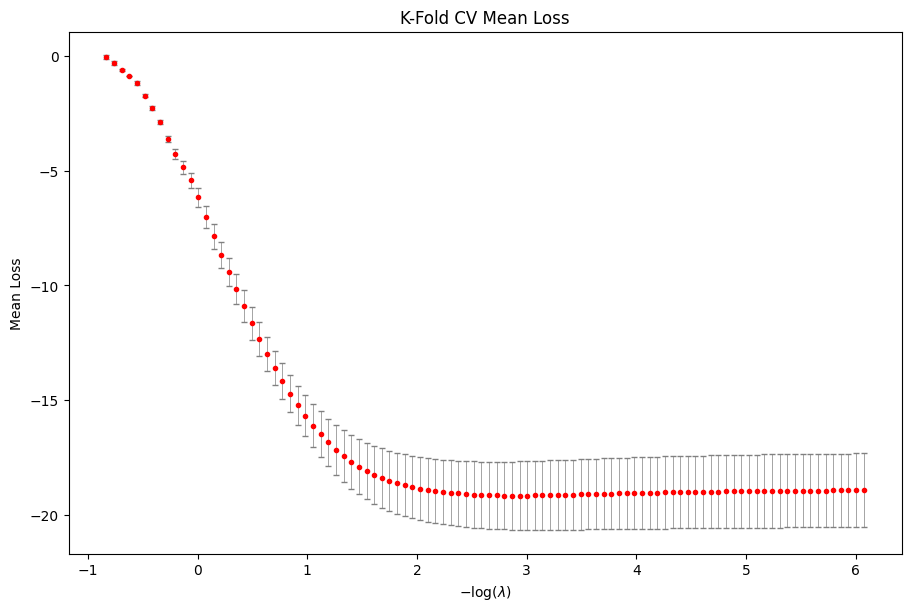

In [8]:
cv_res.plot_loss()
plt.show()

The plot suggests that the best model is somewhere in the middle of the path as the CV loss
dips then flattens as we move down the regularization path.
We now refit lasso along a regularization path which stops at the best chosen $\lambda$.

In [9]:
state = cv_res.fit(
    X=Xc, 
    glm=ad.glm.gaussian(y),
    intercept=False,
)

100%|██████████| 100/100 [00:00:00<00:00:00, 765.17it/s] [dev:44.4%]


We construct the feature importance statistics by taking the last coefficient vector.

In [10]:
beta = state.betas[-1].toarray()[0]
z = np.abs(beta[:p])
z_knock = np.abs(beta[p:])

Next, we construct the *lasso coefficient difference* statistics $W_j = Z_j - \tilde{Z}_j$.
A large positive $W_j$ suggests that the $j$ th (original) feature is important.

In [11]:
w = z - z_knock

Finally, to control FDR, we apply the *Knockoff-filter*.
For a given level $q \in [0,1]$, the Knockoff-filter constructs
$$
\begin{align*}
    \tau_+ = \min\{t > 0 : \frac{1 + |\{j : W_j \leq -t\}|}{|\{j : W_j \geq t\}|} \leq q\}
\end{align*}
$$
and selects features in $\hat{S} = \{j : W_j \geq \tau_+\}$.
This selection procedure controls the FDR so that
$$
\begin{align*}
    \mathbb{E}\left[\frac{|\{j \in \hat{S} \cap \mathcal{H}_0\}|}{|\hat{S}| \vee 1}\right] \leq q
\end{align*}
$$
where $\mathcal{H}_0$ is the true set of null features (in this example, $\mathcal{H}_0 = \{p / 2 + 1,\ldots, p\}$ since the first half of the features is used to construct $y$).

We let $q = 0.05$ in this example and construct $\tau_+$ using `knockpy`.
We then print the *false discovery proportion* (FDP), which is the term inside the expectation above,
and the power estimate, which is the proportion of correctly selected non-nulls over the total number of non-nulls, or
$$
\begin{align*}
    \widehat{\mathrm{Power}} = \frac{|\hat{S} \cap \mathcal{H}_1|}{|\mathcal{H}_1|}
\end{align*}
$$

In [12]:
tau_plus = knockpy.knockoff_stats.data_dependent_threshhold(w, 0.05)
S_hat = np.arange(p)[w >= tau_plus]
H0 = np.arange(n_h1, p)
H1 = np.arange(n_h1)
fdp = len(set(S_hat).intersection(set(H0))) / max(S_hat.shape[0], 1)
pwr = len(set(S_hat).intersection(set(H1))) / n_h1
print(f"FDP:    {fdp}")
print(f"Power:  {pwr}")

FDP:    0.11363636363636363
Power:  0.78


For any one experiment, the FDP may not be under $q$ 
(though we hope the FDP has a small enough variance that it is not too far from its mean).
The guarantee is that if we repeat this entire procedure many times,
the average FDP will be under $q$.

## __Lasso on GWAS Datasets__

In [13]:
import adelie as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pgenlib as pg

In this example, we show how to use `adelie` to run lasso on GWAS datasets.
These datasets often come as 
[.bed](https://www.cog-genomics.org/plink2/formats#bed) or 
[.pgen](https://www.cog-genomics.org/plink/2.0/input#pgen) (PLINK) files
accompanied by other files containing metadata.
The main feature matrix of interest is the *genotype matrix* or a *single-nucleotide polymorphism (SNP) matrix*.
This matrix contains values in the range $\{0,1,2,\mathrm{NA}\}$ with both large number of samples
(e.g. 0.5 million) and features (e.g. 1.7 million).
As a result, special care must be taken to represent such a large matrix to avoid memory issues
and optimize for the matrix operations required to solve the lasso.
The response vector is typically some measurement of a phenotype such as standing height.
The goal is then to learn the association between the genetic information and the phenotype.
We will demonstrate that `adelie` can easily handle such a use-case.

As a reference, we list a few works in the literature that aim to apply lasso on the UK Biobank,
one popular GWAS dataset that has been carefully studied in a wide range of applications.

- [A fast and scalable framework for large-scale and ultrahigh-dimensional sparse regression with application to the UK Biobank](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7641476/)
- [Fast numerical optimization for genome sequencing data in population biobanks](https://academic.oup.com/bioinformatics/article/37/22/4148/6306404)
- [Fast Lasso method for large-scale and ultrahigh-dimensional Cox model with applications to UK Biobank](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9007437/)
- [UK Biobank Multi-modality Brain Age LASSO regression analysis](https://james-cole.github.io/UKBiobank-Brain-Age/)

Since we only wish to demonstrate the workflow of using `adelie` to solve lasso on GWAS datasets,
we work with a small-scale example.
The example dataset is provided in the [data](https://github.com/JamesYang007/adelie/tree/main/data) folder,
which contains PLINK files for the SNP matrix
and a CSV file containing the phenotype and covariates.
The PLINK files are taken from [SnpArrays.jl](https://github.com/OpenMendel/SnpArrays.jl/tree/master/data).
For this demonstration, we randomly generated the phenotype.
The covariates include sex and the 10 largest principle components (PCs) of the SNP matrix.

In the following, we outline the steps of applying `adelie`.

### __Load the Dense SNP Matrix__

The first step is to load the SNP matrix as a dense matrix.
We enforce this for two reasons.
First, we do not wish to have `adelie` depend on any particular third-party file formats.
This extra dependence complicates the maintenance of the package.
Secondly, `adelie` will save the SNP matrix in its own special format (`.snpdat`)
that is optimized for both memory and speed in some matrix operations required by our solver.
Hence, we need to be able to take any user-specified representation of the SNP matrix
and convert it into our format.
We perform this conversion by first asking the user to read the SNP matrix as a dense matrix
then use `adelie` to convert and save the dense matrix as a `.snpdat` file.

__Due to memory issues, the user should not read the full SNP matrix as a dense matrix!__
It is recommended to read them in batches of columns instead.
Typically, we read per chromosome so that we create 22 `.snpdat` files.

We now demonstrate using `pgenlib` how to read the PLINK files as a dense matrix.
For more information on how to use `pgenlib`, we direct the readers to the [GitHub page](https://github.com/BertrandServin/pgenlib).

We first define the data directory and the relevant PLINK file names.

In [14]:
data_dir = "../../../data"
bedname = os.path.join(data_dir, "EUR_subset.bed")
bimname = os.path.join(data_dir, "EUR_subset.bim")
famname = os.path.join(data_dir, "EUR_subset.fam")

We find the number of samples in the dataset by reading the `.fam` file.
This information is required by `pgenlib` since we are working with `.bed` files.

In [15]:
df_fam = pd.read_csv(
    famname, 
    sep=" ", 
    header=None,
    names=["FID", "IID", "Father", "Mother", "Sex", "Phenotype"],
)
n_samples = df_fam.shape[0]
df_fam

,FID,IID,Father,Mother,Sex,Phenotype
0,1,HG00096,0,0,1,1
1,2,HG00097,0,0,2,1
2,3,HG00099,0,0,2,1
3,4,HG00100,0,0,2,1
4,5,HG00101,0,0,1,1
...,...,...,...,...,...,...
374,375,NA20816,0,0,1,1
375,376,NA20818,0,0,2,1
376,377,NA20819,0,0,2,1
377,378,NA20826,0,0,2,1


We read the `.bim` file to retrieve the SNP metadata.
We will use this information to read and process the SNP data per chromosome.

In [16]:
df_bim = pd.read_csv(
    bimname,
    sep="\t",
    header=None,
    names=["chr", "variant", "pos", "base", "a1", "a2"],
)
n_snps = df_bim.shape[0]
df_bim

,chr,variant,pos,base,a1,a2
0,17,rs34151105,0.000000,1665,T,C
1,17,rs143500173,0.000000,2748,T,A
2,17,rs113560219,0.000000,4702,T,C
3,17,rs1882989,0.000056,15222,G,A
4,17,rs8069133,0.000499,32311,G,A
...,...,...,...,...,...,...
54046,22,rs113391741,0.750923,51187440,A,G
54047,22,rs151247655,0.750938,51189403,A,G
54048,22,rs187225588,0.751001,51197602,T,A
54049,22,rs9616967,0.751090,51209343,T,A


Let's try reading the SNP matrix for chromosome `17`.


In [17]:
# create bed reader
reader = pg.PgenReader(
    str.encode(bedname),
    raw_sample_ct=n_samples,
)

# get 0-indexed indices for current chromosome
df_bim_chr = df_bim[df_bim["chr"] == 17]
variant_idxs = df_bim_chr.index.to_numpy().astype(np.uint32)

# read the SNP matrix
geno_out_chr = np.empty((variant_idxs.shape[0], n_samples), dtype=np.int8)
reader.read_list(variant_idxs, geno_out_chr)

# convert to sample-major
geno_out_chr = np.asfortranarray(geno_out_chr.T)

### __Convert to snpdat Format__

Now that we have the dense SNP matrix for chromosome `17`,
we write it in `.snpdat` format using `adelie`.

In [18]:
# define cache directory and snpdat filename
cache_dir = "/tmp"
snpdat_name = os.path.join(cache_dir, "EUR_subset_chr17.snpdat")

# create handler to convert the SNP matrix to .snpdat
handler = ad.io.snp_unphased(snpdat_name)
_ = handler.write(geno_out_chr)

That's it!

### __Process All Chromosomes__

Finally, to mimic the common use-case, 
we combine all the steps to process all the chromosomes.

We first get a list of the chromosomes in the dataset.

In [19]:
chromosomes = df_bim["chr"].unique()
chromosomes

array([17, 18, 19, 20, 21, 22])

The following code saves each SNP matrix per chromosome as a separate `.snpdat` file.

In [20]:
# create bed reader
reader = pg.PgenReader(
    str.encode(bedname),
    raw_sample_ct=n_samples,
)

for chr in chromosomes:
    # get 0-indexed indices for current chromosome
    df_bim_chr = df_bim[df_bim["chr"] == chr]
    variant_idxs = df_bim_chr.index.to_numpy().astype(np.uint32)

    # read the SNP matrix
    geno_out = np.empty((variant_idxs.shape[0], n_samples), dtype=np.int8)
    reader.read_list(variant_idxs, geno_out)

    # define snpdat filename
    snpdat_name = os.path.join(cache_dir, f"EUR_subset_chr{chr}.snpdat")

    # create handler to convert the SNP matrix to .snpdat
    handler = ad.io.snp_unphased(snpdat_name)
    _ = handler.write(geno_out_chr)

### __Load the Feature Matrix__

We first load the covariates as a dense matrix and the phenotype as the response vector.

In [21]:
df = pd.read_csv(os.path.join(data_dir, "master_phe.csv"), sep="\t", index_col=0)
covars_dense = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
df

,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,phenotype
0,0,-0.051678,-0.020465,0.046227,-0.014268,0.085271,-0.002017,-0.010386,0.036105,0.010695,-0.082026,4.612085
1,1,-0.050462,0.008577,-0.058172,-0.048560,0.014092,-0.008358,-0.045067,-0.005221,0.098964,0.019094,5.175936
2,1,-0.051158,0.013547,-0.041690,-0.023781,-0.057576,0.088412,0.025772,0.082086,-0.099380,0.016369,13.531050
3,1,-0.051310,-0.021508,0.049910,-0.038484,0.006369,0.001142,0.063346,0.045536,0.021950,-0.019257,188.524040
4,0,-0.051329,0.014914,-0.067042,-0.069162,-0.023286,0.006299,-0.032645,-0.019187,-0.006523,-0.033779,65.697673
...,...,...,...,...,...,...,...,...,...,...,...,...
374,0,-0.051168,-0.048192,0.025948,0.044251,-0.025641,0.000769,0.057611,0.052506,-0.065036,-0.034339,91.516444
375,1,-0.051801,-0.055517,-0.004016,-0.021153,-0.007273,-0.041470,-0.061246,-0.015746,0.020271,0.014094,74.187329
376,1,-0.052525,-0.022246,-0.056309,0.092208,-0.036200,0.070898,-0.010716,0.055041,-0.086128,-0.041673,77.536242
377,1,-0.051577,-0.081801,0.113044,0.024027,0.046088,-0.002275,0.008942,0.020224,0.038375,-0.036612,264.019774


Once the SNP matrices have been processed into `.snpdat` files,
we may now load this information as a `adelie.matrix.snp_unphased` object per file.
This matrix class implements certain matrix operations highly efficiently for SNP matrices
and is recognized by our solver.
Finally, we column-wise concatenate all these matrices as well as the dense covariates.

In [22]:
X = ad.matrix.concatenate(
    [ad.matrix.dense(covars_dense)]
    + [
        ad.matrix.snp_unphased(
            ad.io.snp_unphased(
                os.path.join(cache_dir, f"EUR_subset_chr{chr}.snpdat"),
            )
        )
        for chr in chromosomes
    ],
    axis=1,
)
X.shape

(379, 66257)

### __Fit Lasso__

We fit lasso using `X` and `y` under the Gaussian loss with intercept.
Note that we unpenalize the covariates.

In [23]:
penalty = np.concatenate([
    np.zeros(covars_dense.shape[-1]),
    np.ones(X.shape[-1] - covars_dense.shape[-1]),
])

In [24]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y),
    penalty=penalty,
)

 44%|████      | 44/100 [00:00:00<00:00:01, 55.52it/s] [dev:90.3%]


### __Run Diagnostics (optional)__

The user may wish to look at some diagnostic information afterwards.
Here is an example of plotting the training $R^2$.

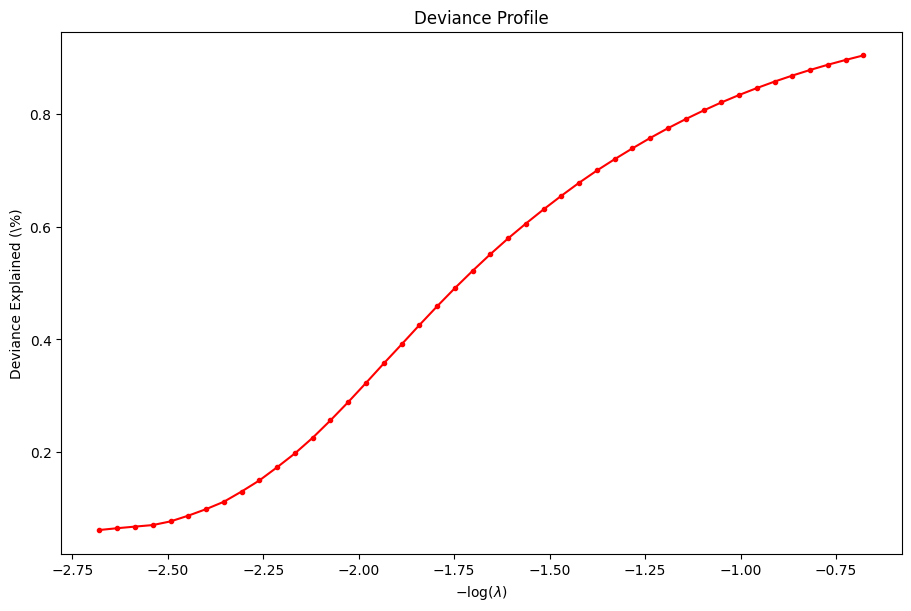

In [25]:
dg = ad.diagnostic.diagnostic(state)
dg.plot_devs()
plt.show()

### __Cross-Validation__

If the dataset contains few samples, the user may be interested in using cross-validation
to determine the best model.

To demonstrate this, we run a 5-fold cross-validation on our dataset.

In [26]:
cv_res = ad.cv_grpnet(
    X=X,
    glm=ad.glm.gaussian(y),
    seed=3,
)

100%|██████████| 100/100 [00:00:01<00:00:00, 55.79it/s] [dev:93.8%]


We can visualize the average cross-validation loss in the following way.

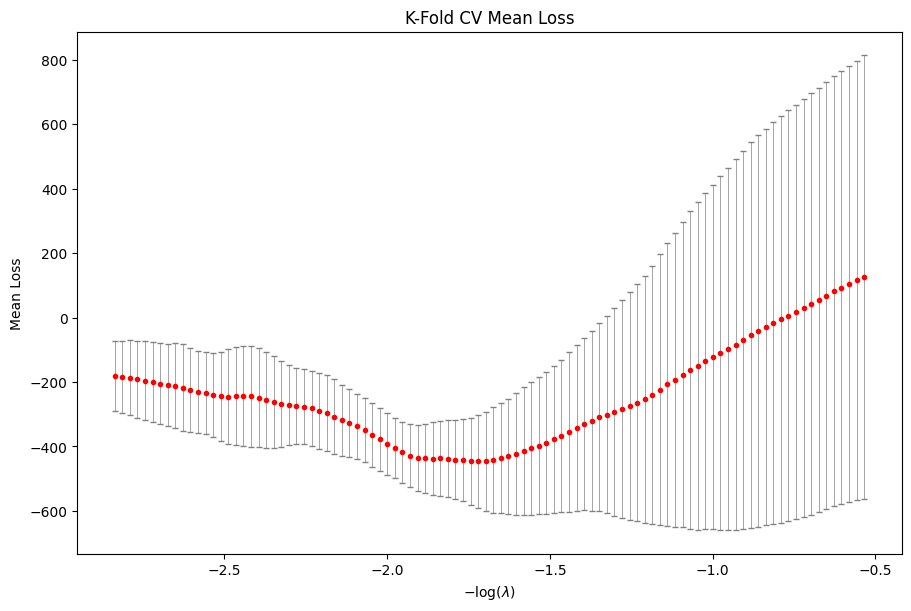

In [27]:
cv_res.plot_loss()
plt.show()

In this example, the best model chosen by 5-fold CV is at index `48` of the $\lambda$ sequence.

In [28]:
cv_res.best_idx

48

To refit the model at the best model, run the following:

In [29]:
state = cv_res.fit(
    X=X,
    glm=ad.glm.gaussian(y),
)

100%|██████████| 100/100 [00:00:01<00:00:00, 72.60it/s] [dev:51.7%]


The last fitted regularization value is the one corresponding to the best model.

### __Clean-up Files__

Once we are done analyzing the dataset, we may remove the `.snpdat` files that we created.

In [30]:
for chr in chromosomes: 
    os.remove(os.path.join(cache_dir, f"EUR_subset_chr{chr}.snpdat"))

## __SNP Phased Ancestry__

The usual phased calldata is a `(n, 2s)` matrix of type `np.int8` since the entries are one of `{0,1}` (assuming no missing values), where `n` is the number of observations and `s` is the number of SNPs.
The factor of `2` comes from the fact that there are always 2 haplotypes.
The ancestry information is also a `(n, 2s)` matrix of type `np.int8` where each entry
takes on a value in `{0,1,..., A-1}` where `A` is the number of ancestry categories.
Each ancestry information corresponds to the individual, haplotype, and SNP as in the calldata.
We assume that the user has access to a dense matrix of the phased calldata 
and the corresponding ancestry information prior to using `adelie`.

The data matrix we ultimately want to use is the sum of the ancestry-expanded calldata for each haplotype, described next.
Fix a haplotype, and consider the corresponding calldata and ancestry matrix.
For each `(i,j)` entry of the calldata, suppose it is exanded into a length `A` vector
where a mutation is recorded in entry `k` if the ancestry at `(i,j)` is `k` (and zero otherwise).
The concatenation of all these expanded vectors results in `(n, As)` matrix.
Then, we wish to run group lasso by grouping every `A` columns as a group (i.e. SNP).

To fully mimic the real application, we assume that the calldata is split into chromosomes
so that we load column-blocks of the calldata, one chromosome at a time.
We will generate `n` observations and `ss[i]` SNPs per chromosome for each chromosome `i`.

In [31]:
n = 1000                        # number of observations
ss = [1000, 2000, 3000]         # number of SNPs per chromosome (3 chromosomes)
A = 8                           # number of ancestries
n_threads = 1                   # number of threads

Similar to the unphased calldata example,
we generate our data for each chromosome using a helper function 
and store a sparse representation in `/tmp/spa_chr_i.snpdat` for each chromosome `i`.

In [32]:
filenames = [
    f"/tmp/spa_chr_{i}.snpdat"
    for i in range(len(ss))
]
for i, s in enumerate(ss):
    data = ad.data.snp_phased_ancestry(n, s, A)
    handler = ad.io.snp_phased_ancestry(filenames[i])
    handler.write(data["X"], data["ancestries"], A, n_threads)

We then instantiate our special matrix object for phased ancestry SNP data.

In [33]:
X = ad.matrix.concatenate(
    [
        ad.matrix.snp_phased_ancestry(
            ad.io.snp_phased_ancestry(filename), 
            n_threads=n_threads,
        )
        for filename in filenames
    ],
    axis=1,
    n_threads=n_threads,
)

For demonstration purposes, we generate our response vector `y` from a linear model
with only the last three SNPs active in the model.

In [34]:
s = int(np.sum(ss))
p = A * s

np.random.seed(314)
beta = np.random.normal(0, 1, 3*A)
Xb = np.zeros(n)
X.btmul(p-3*A, 3*A, beta, Xb)
y = Xb + np.random.normal(0, 1, n)

Finally, we use `adelie` to fit group lasso!

In [35]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y=y),
    groups=A * np.arange(s),
    n_threads=n_threads,
)

 62%|██████    | 62/100 [00:00:00<00:00:00, 136.40it/s] [dev:90.5%]


Now, we can use our diagnostic object to inspect our solutions.
For example, we can plot the coefficients.

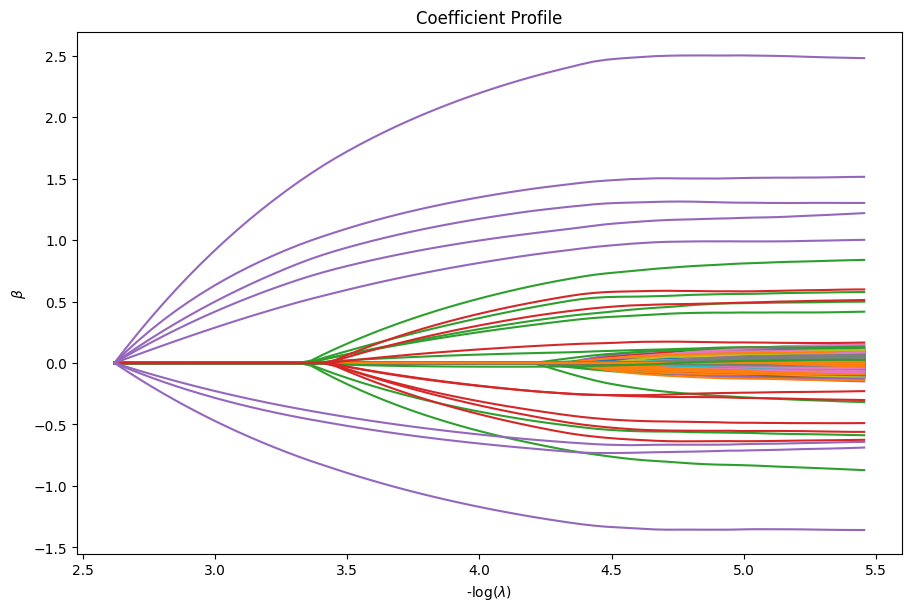

In [36]:
dg = ad.diagnostic.diagnostic(state)
dg.plot_coefficients()
plt.show()

In [37]:
# clean-up generated files!
for filename in filenames: os.remove(filename)